Latest Rates on 2024-12-20 00:00:00:
1M     4.43
6M     4.29
1Y     4.27
5Y     4.37
10Y    4.52
30Y    4.72
Name: 2024-12-20 00:00:00, dtype: float64


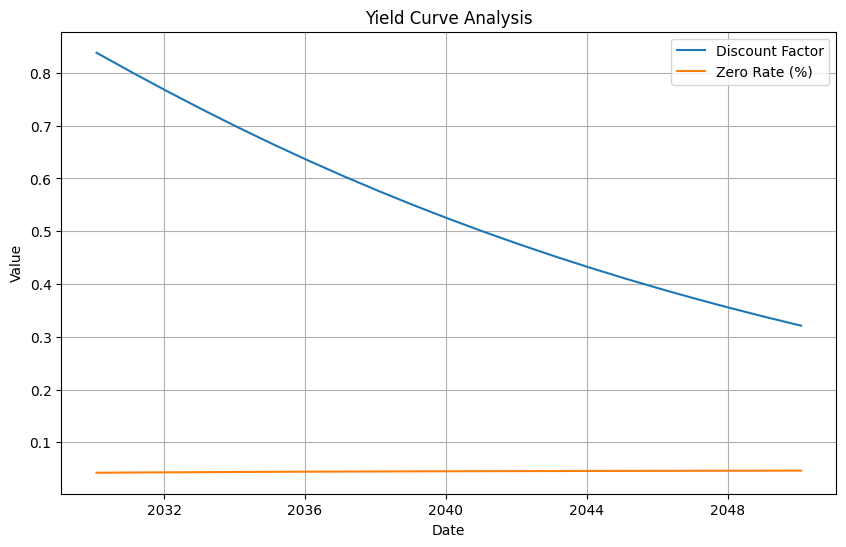

Extrapolated Zero Rate (2055): 4.68%


In [11]:
import QuantLib as ql
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Set your FRED API key
FRED_API_KEY = 'a06c7d16df6e6fd58ade2960fc20bba1'
fred = Fred(api_key=FRED_API_KEY)

# Define the settlement date
settlement_date = ql.Date(26, 12, 2025)  # Day, Month, Year
ql.Settings.instance().evaluationDate = settlement_date

# Fetch FRED Treasury Yield Data
# Adjust maturities based on FRED series
yield_data = {
    '1M': fred.get_series('DGS1MO'),
    '6M': fred.get_series('DGS6MO'),
    '1Y': fred.get_series('DGS1'),
    '5Y': fred.get_series('DGS5'),
    '10Y': fred.get_series('DGS10'),
    '30Y': fred.get_series('DGS30')
}

# Convert FRED data to a DataFrame and drop NaN values
yield_curve_df = pd.DataFrame(yield_data).dropna()

# Use the latest available rates
latest_date = yield_curve_df.index[-1]
rates = yield_curve_df.iloc[-1]
print(f"Latest Rates on {latest_date}:")
print(rates)

# Create Rate Helpers for QuantLib
calendar = ql.UnitedStates(m = ql.UnitedStates.GovernmentBond)
rates_helpers = []

# Define deposit and bond helpers based on FRED maturities
maturity_map = {
    '1M': ql.Period(1, ql.Months),
    '6M': ql.Period(6, ql.Months),
    '1Y': ql.Period(1, ql.Years),
    '5Y': 5,  # Bond maturity in years
    '10Y': 10,  # Bond maturity in years
    '30Y': 30   # Bond maturity in years
}

# Add Deposit Helpers
for key, maturity in maturity_map.items():
    if isinstance(maturity, ql.Period):  # Deposits
        rates_helpers.append(
            ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(rates[key] / 100)),
                maturity,
                2,  # Settlement days
                calendar,
                ql.ModifiedFollowing,
                False,
                ql.Actual360()
            )
        )
    else:  # Bonds
        bond_schedule = ql.Schedule(
            settlement_date,
            ql.Date(settlement_date.dayOfMonth(), settlement_date.month(), settlement_date.year() + maturity),
            ql.Period(ql.Annual),
            calendar,
            ql.ModifiedFollowing,
            ql.ModifiedFollowing,
            ql.DateGeneration.Backward,
            False
        )
        rates_helpers.append(
            ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(100)),  # Assume par price
                3,  # Settlement days
                100,  # Face value
                bond_schedule,
                [rates[key] / 100],  # Coupon rate
                ql.Actual360(),
                ql.ModifiedFollowing
            )
        )

# Build Yield Curve using QuantLib
yield_curve = ql.PiecewiseLogCubicDiscount(settlement_date, rates_helpers, ql.Actual360())

# Enable extrapolation for longer maturities
yield_curve.enableExtrapolation()

# Query the curve for discount factors and zero rates
dates = [ql.Date(30, 1, year) for year in range(2030, 2051)]
discount_factors = [yield_curve.discount(d) for d in dates]
zero_rates = [
    yield_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates
]

# Convert dates to Python datetime for plotting
plot_dates = [pd.Timestamp(d.year(), d.month(), d.dayOfMonth()) for d in dates]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(plot_dates, discount_factors, label="Discount Factor")
plt.plot(plot_dates, zero_rates, label="Zero Rate (%)")
plt.title("Yield Curve Analysis")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Example: Extrapolate to 2055
extrapolated_rate = yield_curve.zeroRate(
    ql.Date(30, 1, 2055), ql.Actual360(), ql.Continuous
).rate()
print(f"Extrapolated Zero Rate (2055): {extrapolated_rate:.2%}")


In [12]:
# Discount factor
discount_factor = yield_curve.discount(ql.Date(2, 1, 2030))
print(f"Discount factor for 2 Jan 2030: {discount_factor}")

# Forward rate
forward_rate = yield_curve.forwardRate(
    ql.Date(2, 1, 2030),
    ql.Date(2, 1, 2031),
    ql.Actual360(),
    ql.Simple
).rate()
print(f"Forward rate for 2030-2031: {forward_rate:.2%}")


Discount factor for 2 Jan 2030: 0.841035766347854
Forward rate for 2030-2031: 4.53%


In [20]:
import QuantLib as ql

# Define today's date
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today

# Define option details
expiry_date = ql.Date(19, 12, 2025)  # Expiry date: Dec 19, 2025
strike_price = 230.0  # Strike price
option_type = ql.Option.Call  # Call option

# Define market data
spot_price = 229.78  # Replace with the current price of Amazon
implied_volatility = 0.3289  # Implied volatility (32.89%)
risk_free_rate = 0.0427  # Risk-free rate (5%)
dividend_yield = 0.0  # No dividends

# Define the yield term structures
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
risk_free_curve = ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, ql.Actual365Fixed()))
dividend_curve = ql.YieldTermStructureHandle(ql.FlatForward(today, dividend_yield, ql.Actual365Fixed()))
volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), implied_volatility, ql.Actual365Fixed()))

# Define the option payoff and exercise
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.AmericanExercise(today, expiry_date)  # American exercise (can exercise anytime)

# Define the option
option = ql.VanillaOption(payoff, exercise)

# Define the Black-Scholes process
bs_process = ql.BlackScholesMertonProcess(spot_handle, dividend_curve, risk_free_curve, volatility_handle)

# Use Monte Carlo engine for American options
engine = ql.MCAmericanEngine(
    bs_process,
    "pseudorandom",  # Random number generator
    timeSteps=200,  # Number of time steps
    requiredSamples=100000,  # Number of Monte Carlo paths
    antitheticVariate=True,  # Use antithetic variates for variance reduction
    seed=42  # Random number seed, helps you for reproducibility, when you chagne small aspects and want the same sequence of random numbers
)
option.setPricingEngine(engine)

""" 

The random numbers we use in the Monte Carlo simulation help us to simulate stock price paths which are stochastic in nature, 

and have a variable z, which is a random number that helps to deal with the randomness in the market and in asset pricing.

"""
# Calculate and print the option price
option_price = option.NPV()
print(f"The price of the American call option is: ${option_price:.2f}")


The price of the American call option is: $33.36
